In [188]:
# Initialize the environment
# Update: 2018-11-27

import numpy as np
import platform
import tempfile
import os
import math
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import io, color
from scipy.fftpack import dct
from scipy.stats import binom

In [189]:
im=io.imread('pelican.png')
im2=io.imread('lena5.jpg')
im = color.rgb2ycbcr(im)
im2 = color.rgb2ycbcr(im2)

votes = np.zeros((2,3)) # Table des votes
print(votes)
votes[1,2] = 1
print(votes)

[[0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 1.]]


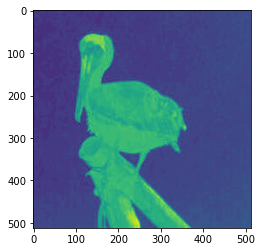

In [190]:
def im_luminance(im):
    if len(im.shape) == 3:
        R, G, B = im[:,:,0], im[:,:,1], im[:,:,2]
        luminance = 0.299*R + 0.587*G + 0.114*B
    else:
        luminance = im
    return luminance

plt.imshow(im[:,:,2])


In [191]:
def BinTail(n,k,p):
    return 1-binom.cdf(k-1,n,p)

In [192]:
def NFA(nvotes,X,Y) : # on lui donne en entrée le nombre de votes pour la grille sur laquelle on veut calculer le NFA, et la taille de l'image
    p = 1/64
    n=(X*Y)/64
    nvotes2 = nvotes/64
    # Remarque : on pourrait calculer nvotes directement à l'intérieur de cette fonction, mais il faudrait lui donner la carte des votes.
    return ((X*Y*64)**2)*BinTail(n,nvotes2,p)


In [193]:
def voteMAP(image): # image en luminance
    shape = image.shape
    X = shape[0]
    Y = shape[1]
    votes = np.zeros((X,Y)) # Table des votes
    zeros = np.zeros((X,Y)) # Table des zeros
    # DCT par blocs de 8x8 pixels
    for x in range(X - 7):
        for y in range(Y - 7):
            z = 0 # Nombre de zeros dans le bloc
            bloc = image[x:x+8,y:y+8,0]
            cx = True
            cy = True
            while (cx or cy): #On verifie que le bloc n'est pas constant
                for xx in range(8):
                    for yy in range(8):
                        if bloc[xx,yy] != bloc[xx,0]: #On verifie que le bloc n'est pas constant selon x
                            cx = False
                        if bloc[xx,yy] != bloc[0,yy]: #idem pour y
                            cy = False

            dctblock = dct(dct(bloc.T, norm='ortho').T, norm='ortho') # DCT du bloc
            for xx in range(8):
                for yy in range(8):
                    if abs(dctblock[xx,yy]) < 0.5:
                        z += 1 # On compte les zeros
            
            for xx in range(x, x + 8): # On vote pour le bloc
                for yy in range(y, y + 8):
                    if z > 0 and z > votes[xx,yy]:
                        if cx or cy:
                            votes[xx,yy] = -1
                        else:
                            zeros[xx,yy] = z
                            votes[xx,yy] = (x%8 + y%8 * 8) # On vote pour la meilleure grille
                        
    # On elimine les bordures de l'image
    for xx in range(X):
        for yy in range(7):
            votes[xx,yy] = -1
        for yy in range(Y - 7, Y):
            votes[xx,yy] = -1
    for yy in range(Y):
        for xx in range(7):
            votes[xx,yy] = -1
        for xx in range(X - 7, X):
            votes[xx,yy] = -1
    
    return votes

In [194]:
def detectgrid (im) : # le but de la fonction est de detecter la grille la plus presente dans l'image et de la renvoyer (on renvoye aussi maxvote juste comme indicateur)
    shape = im.shape
    X = shape[0]
    Y = shape[1]  
    votes = voteMAP(im)
    gridvotes = np.zeros((8,8))
    maxvote = 0
    mostvotedgrid = (0,0)
    for x in range(X) :
        for y in range(Y) :
            if isinstance(int(votes[x,y]),int) :
                print("vote : ",int(votes[x,y]))
                if int(votes[x,y]) != -1 :
                    gridvotes[np.unravel_index(int(votes[x,y]),(8,8))]+=1
                    if gridvotes[np.unravel_index(int(votes[x,y]),(8,8))]> maxvote :
                        maxvote = gridvotes[np.unravel_index(int(votes[x,y]),(8,8))]
                        mostvotedgrid = np.unravel_index(int(votes[x,y]),(8,8))
    NFAv = NFA(maxvote,X,Y)
    if NFAv<1 :
        print("La grille la plus presente dans l'image est la grille de coordonnees : ",mostvotedgrid," avec ",maxvote," votes")
        print("Le NFA de cette grille est : ",NFAv)
        return mostvotedgrid, maxvote  # on renvoie la grille la plus presente dans l'image sous forme de tuple (x,y) entre 0 et 7
    else :
        print("Il n'y a pas de grille dans l'image car NFA > 1")
        return (0,0),0
    

In [195]:
def votesforeachpixel(im) :
    shape = im.shape
    X = shape[0]
    Y = shape[1]  
    zeros = np.zeros((X,Y))
    votes = np.zeros((X,Y))
    for x in range(X-7) :
        for y in range(Y-7) :
            block = im[x:x+8,y:y+8,0]
            constantx = False
            constanty = False
            #on regarde si le block est constant selon x ou y
            for xx in range(8) :
                for yy in range(8) :
                    if block[xx,yy] == block [xx,0] :
                        constanty = True

                    if block[xx,yy] == block [0,yy] :
                        constantx = True

            dctblock = dct(dct(block, axis=0, norm='ortho'), axis=1, norm='ortho')
            nbzeros = 0

            for i in range(8) :
                for j in range(8) :
                    if abs(dctblock[i,j])<0.5 :
                        nbzeros+=1
            for xx in range(8) :
                for yy in range(8) :
                    if nbzeros>zeros[x+xx,y+yy] :
                        zeros[x+xx,y+yy] = nbzeros
                        if not (constantx or constanty) :
                            votes[x+xx,y+yy]= (x%8,y%8)
    return votes # on renvoie un tableau de taille X*Y*2 avec en chaque point le vote pour la grille la plus presente. 
# Ce vote correspond a un tuple (x,y) entre 0 et 7

In [196]:
print(detectgrid(im2))

KeyboardInterrupt: 

In [ ]:
def zero(input, image, luminance, luminance_jpeg, votes, votes_jpeg, lnfa_grids, foreign_regions, foreign_regions_n, missing_regions, missing_regions_n, mask_f, mask_f_reg, mask_m, mask_m_reg, X, Y, C, C_jpeg):
    main_grid = -1
    im = im_luminance(image)
    main_grid = detectgrid(im)
    foreign_regions_n[0] = detect_forgeries(votes, mask_f, mask_f_reg, foreign_regions, X, Y, main_grid, 63)
    if main_grid > -1 and image is not None:
        im_luminance(image, luminance_jpeg, X, Y, C_jpeg)
        voteMAP(luminance_jpeg, votes_jpeg, X, Y)
        for x in range(X):
            for y in range(Y):
                if votes[x+y*X] == main_grid:
                    votes_jpeg[x+y*X] = -1
        missing_regions_n[0] = detect_forgeries(votes_jpeg, mask_m, mask_m_reg, missing_regions, X, Y, -1, 0)

    return main_grid
